In [1]:
! pip install gpytorch

In [2]:
import gpytorch
print(gpytorch.__version__)

1.5.1


In [3]:
import sys
import os
import subprocess
import tarfile
import shutil
import types
import math
import pickle

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as dist
from torch.autograd import grad
import gpytorch

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

import boda
from boda.generator import plot_tools
from boda.common import constants

boda_src = os.path.join( os.path.dirname( os.path.dirname( os.getcwd() ) ), 'src' )
sys.path.insert(0, boda_src)

from main import unpack_artifact, model_fn

from scipy import spatial
from scipy.cluster import hierarchy
from scipy.stats import spearmanr


In [4]:
if os.path.isdir('./artifacts'):
    shutil.rmtree('./artifacts')

hpo_rec = 'gs://syrgoth/aip_ui_test/model_artifacts__20211108_083428__116627.tar.gz'

unpack_artifact(hpo_rec)

model_dir = './artifacts'

my_model = model_fn(model_dir)
my_model.cuda()
my_model.eval()

left_flank = boda.common.utils.dna2tensor( 
    boda.common.constants.MPRA_UPSTREAM[-200:] 
).unsqueeze(0)
print(f'Left flanking sequence shape: {left_flank.shape}')

right_flank= boda.common.utils.dna2tensor( 
    boda.common.constants.MPRA_DOWNSTREAM[:200] 
).unsqueeze(0)
print(f'Left flanking sequence shape: {right_flank.shape}')

Loaded model from 20211108_083428 in eval mode
Left flanking sequence shape: torch.Size([1, 4, 200])
Left flanking sequence shape: torch.Size([1, 4, 200])


In [5]:
class SequenceFeatureExtractor(nn.Module):
    def __init__(self, model, input_dims=[1,4,200], hidden_name='encode'):
        super().__init__()
        self.model = model
        bsz, n_feat = getattr(self.model, hidden_name)( 
            torch.randn(input_dims).to(self.model.device) 
        ).shape
        self.reducer = nn.Linear(n_feat, 16)
        self.reducer.to(self.model.device)
        
    def forward(self, input, hidden_name='encode'):
        return self.reducer( getattr(self.model, hidden_name)(input) )

In [6]:
class EmbeddingFeatureExtractor(nn.Module):
    def __init__(self, n_out, source_model, input_dims=[1,4,200], hidden_name='encode'):
        super().__init__()
        bsz, n_feat = getattr(source_model, hidden_name)( 
            torch.randn(input_dims).to(source_model.device) 
        ).shape
        self.n_out = n_out
        self.reducer = nn.Linear(n_feat, n_out)
        print(f"Extractor to convert n_in: {n_feat} to n_out: {n_out}")
    
    def forward(self, embedding):
        return self.reducer(embedding)


In [7]:
short_model = EmbeddingFeatureExtractor(16, my_model)
short_model.cuda()

print(f'model size: {sum([ x.numel() for x in list( short_model.parameters() ) ])}')

short_model( torch.randn(10,800).cuda() ).shape

Extractor to convert n_in: 800 to n_out: 16
model size: 12816


torch.Size([10, 16])

In [8]:
class GPRegressionModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, feature_extractor):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module= gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.keops.RBFKernel(ard_num_dims=feature_extractor.n_out)
        )
        self.feature_extractor = feature_extractor
        
        self.scale_to_bounds = gpytorch.utils.grid.ScaleToBounds(-10., 10.)
        
    def forward(self, x):
        projected_x = self.feature_extractor(x)
        scaled_x    = self.scale_to_bounds(projected_x)
        
        mean_x = self.mean_module(scaled_x)
        covar_x= self.covar_module(scaled_x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [9]:
data_module = getattr(boda.data, 'MPRA_DataModule')
data = data_module(datafile_path='gs://syrgoth/data/MPRA_ALL_HD_v2.txt', data_project=['BODA', 'UKBB'], padded_seq_len=600)
data.setup()


--------------------------------------------------

K562 | top cut value: 11.03, bottom cut value: -6.01
HepG2 | top cut value: 10.01, bottom cut value: -5.2
SKNSH | top cut value: 10.06, bottom cut value: -5.34

Number of examples discarded from top: 0
Number of examples discarded from bottom: 0

Number of examples available: 319561

--------------------------------------------------

Padding sequences...
Tokenizing sequences...
Creating train/val/test datasets...
--------------------------------------------------

Number of examples in train: 276121 (86.41%)
Number of examples in val:   15566 (4.87%)
Number of examples in test:  27874 (8.72%)

Excluded from train: 0 (0.0)%
--------------------------------------------------


In [10]:
bias_cell = 0
max_examples = None
X_train, Y_train = [ torch.stack(z, dim=0) for z in zip(*data.dataset_train) ]
X_train = X_train[:max_examples, :, 200:400]
Y_train = Y_train[:max_examples,bias_cell]

bsz = 128

enc_ = []

with torch.no_grad():
    for i in range((X_train.shape[0]//bsz)+1):
        X_batch = X_train[i*bsz:(i+1)*bsz]
        encoded = my_model.encode(X_batch.to(my_model.device))
        
        enc_.append(encoded.cpu())
        
X_train = torch.cat(enc_, dim=0)

X_train = X_train.contiguous()
Y_train = Y_train.contiguous()

print(X_train.shape)
print(Y_train.shape)

torch.Size([276121, 800])
torch.Size([276121])


In [11]:
max_examples = None
X_test, Y_test = [ torch.stack(z, dim=0) for z in zip(*data.dataset_test) ]
X_test = X_test[:max_examples, :, 200:400]
Y_test = Y_test[:max_examples,bias_cell]

enc_ = []

with torch.no_grad():
    for i in range((X_test.shape[0]//bsz)+1):
        X_batch = X_test[i*bsz:(i+1)*bsz]
        encoded = my_model.encode(X_batch.to(my_model.device))
        
        enc_.append(encoded.cpu())
        
X_test = torch.cat(enc_, dim=0)

X_test = X_test.contiguous()
Y_test = Y_test.contiguous()

print(X_test.shape)
print(Y_test.shape)

torch.Size([27874, 800])
torch.Size([27874])


In [12]:
def degeneracy_filter(in_tensor, max_degeneracy=1.):
    mode_check = in_tensor.cpu() == in_tensor.cpu().mode(dim=0).values
    return torch.tensor([ val < int(max_degeneracy*mode_check.shape[0]) for val in mode_check.sum(0) ])

Check encoder degeneracy.
proportion equal to mode


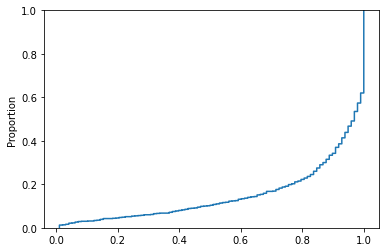

proportion different from mode


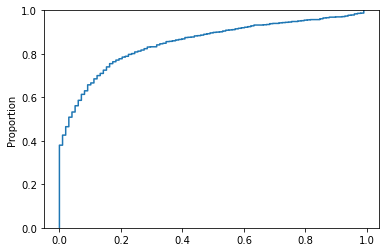

encoder: 496 passed features


In [13]:
print("Check encoder degeneracy.")

with torch.no_grad():
    p = []
    t = 0
    mode_check = encoded.cpu() == encoded.cpu().mode(dim=0).values
    for i, val in enumerate(mode_check.sum(0)):
        p.append( (val.item() / mode_check.shape[0]) )
    p = np.array(p)

print('proportion equal to mode')
sns.ecdfplot(p)
plt.show()
print('proportion different from mode')
sns.ecdfplot(1-p)
plt.show()

enc_filter = degeneracy_filter(encoded, 1.)
print(f'encoder: {enc_filter.sum()} passed features')

In [14]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = GPRegressionModel(X_train, Y_train, likelihood, short_model)

if torch.cuda.is_available():
    model = model.cuda()
    likelihood = likelihood.cuda()

In [19]:
training_iterations = 200

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': model.feature_extractor.parameters()},
    {'params': model.covar_module.parameters()},
    {'params': model.mean_module.parameters()},
    {'params': model.likelihood.parameters()},
], lr=0.01)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

def train():
    iterator = tqdm(range(training_iterations))
    for i in iterator:
        # Zero backprop gradients
        optimizer.zero_grad()
        # Get output from model
        output = model(X_train.cuda())
        # Calc loss and backprop derivatives
        loss = -mll(output, Y_train.cuda())
        loss.backward()
        iterator.set_postfix(loss=loss.item())
        optimizer.step()


In [16]:
%time train()

  0%|          | 0/200 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:234: UserWarning: An output with one or more elements was resized since it had shape [11], which does not match the required output shape [1, 11].This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at  /opt/conda/conda-bld/pytorch_1634272178570/work/aten/src/ATen/native/Resize.cpp:23.)
  torch.sum(mul_storage, -2, keepdim=True, out=alpha)
  2%|▏         | 4/200 [02:18<1:53:12, 34.65s/it, loss=0.969]


KeyboardInterrupt: 

In [17]:
%%time

# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(X_test.cuda()))
    mean = observed_pred.mean
    lower, upper = observed_pred.confidence_region()

CPU times: user 2min 15s, sys: 108 ms, total: 2min 16s
Wall time: 2min 16s


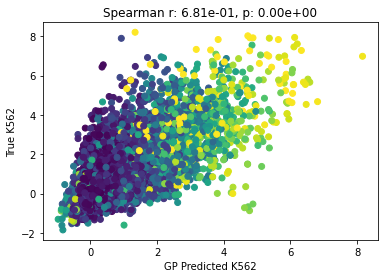

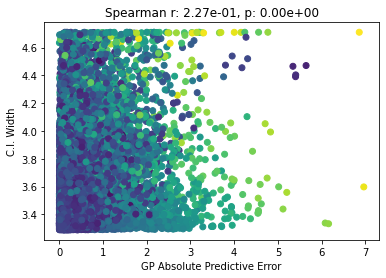

In [18]:
plt.scatter( mean.cpu().numpy(), Y_test.cpu().numpy(), c=(upper-lower).cpu().numpy(), cmap='viridis' )
corr, pval = spearmanr( mean.cpu().numpy(), Y_test.cpu().numpy() )
plt.title("Spearman r: {:.2e}, p: {:.2e}".format(corr,pval))
plt.xlabel("GP Predicted K562")
plt.ylabel("True K562")
plt.show()

plt.scatter( (mean.cpu()-Y_test.cpu()).abs().numpy(), (upper-lower).cpu().numpy(), c=Y_test.cpu(), cmap='viridis' )

corr, pval = spearmanr( (mean.cpu()-Y_test.cpu()).abs().numpy(), (upper-lower).cpu().numpy() )
plt.title("Spearman r: {:.2e}, p: {:.2e}".format(corr,pval))
plt.xlabel("GP Absolute Predictive Error")
plt.ylabel("C.I. Width")

plt.show()


In [5]:
class MyEnergy(torch.nn.Module):
    
    def __init__(self, model, left_flank, right_flank, bias_cell=None, bias_alpha=1.):
        super().__init__()
        
        self.model = model
        self.model.eval()
        
        self.register_buffer('left_flank', left_flank.to(model.device))
        self.register_buffer('right_flank', right_flank.to(model.device))
        
        self.bias_cell = bias_cell
        self.bias_alpha= bias_alpha
        
    def add_flanks(self, x):
        try:
            expand_left  = self.left_flank.expand(self.batch_size, -1, -1)
            expand_right = self.right_flank.expand(self.batch_size, -1, -1)
            return torch.cat([ expand_left, x, expand_right ], dim=-1)
        except (AttributeError, RuntimeError) as e:
            self.batch_size = x.shape[0]
            return self.add_flanks(x)
        
    def forward(self, x):
        hook = x.to(self.model.device)
        
        hook = self.add_flanks(hook)
                
        hook = self.model(hook)
        
        if self.bias_cell is not None:
            hook = hook[...,[ x for x in range(hook.shape[-1]) if x != self.bias_cell]].max(-1).values \
                     - hook[...,self.bias_cell].mul(self.bias_alpha)
        else:
            hook = boda.graph.utils.shannon_entropy(hook)

        return hook
    
    def encode(self, x):
        hook = x.to(self.model.device)
        
        hook = self.add_flanks(hook)
        
        hook = self.model.encode(hook)
        
        return hook
    
    def encode_and_decode(self, x):
        hook = x.to(self.model.device)
        
        hook = self.add_flanks(hook)
        
        hook = self.model.encode(hook)
        
        return hook, self.model.decode(hook)
    
    def encode_and_decode_and_pred(self, x):
        hook = x.to(self.model.device)
        
        hook = self.add_flanks(hook)
        
        ec = self.model.encode(hook)
        
        dc = self.model.decode(ec)
        
        pre= self.model.classify(dc)
        
        return ec, dc, pre

In [6]:
my_energy = MyEnergy(my_model, left_flank, right_flank, bias_cell=None, bias_alpha=1.)

In [8]:
print( len(data.chr_dataset_train) )
for batch in data.chr_dataset_train:
    x, y = batch
    print(x.shape)
    print(y.shape)
    break

10993
torch.Size([4, 600])
torch.Size([3])


In [9]:
X, Y = [ torch.stack(z, dim=0) for z in zip(*data.dataset_train) ]
X = X[:, :, 200:400]
Y = Y[:,0]
print(X.shape)
print(Y.shape)

bsz = 1000

enc_ = []
dec_ = []
pre_ = []

with torch.no_grad():
    for i in range((X.shape[0]//bsz)+1):
        X_batch = X[i*bsz:(i+1)*bsz]
        encoded, decoded, preds = my_energy.encode_and_decode_and_pred(X_batch)
        
        enc_.append(encoded)
        dec_.append(decoded)
        pre_.append(preds)
        
encoded = torch.cat(enc_, dim=0)
decoded = torch.cat(dec_, dim=0)
preds   = torch.cat(pre_, dim=0)
    
print(encoded.shape)
print(decoded.shape)
print(preds.shape)

torch.Size([22759, 4, 200])
torch.Size([22759])


/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)


torch.Size([22759, 2600])
torch.Size([22759, 1290])
torch.Size([22759, 3])


In [10]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
        
        self.covar_module = gpytorch.kernels.MultiDeviceKernel(
            base_covar_module, device_ids=range(n_devices),
            output_device=output_device

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(encoded, Y, likelihood)

In [11]:
X, decoded, Y, model, likelihood = X.cuda(), decoded.cuda(), Y.cuda(), model.cuda(), likelihood.cuda()

In [12]:
%%time

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

training_iter = 100
for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(encoded)
    # Calc loss and backprop gradients
    loss = -mll(output, Y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()

/opt/conda/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:234: UserWarning: An output with one or more elements was resized since it had shape [11], which does not match the required output shape [1, 11].This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at  /pytorch/aten/src/ATen/native/Resize.cpp:23.)
  torch.sum(mul_storage, -2, keepdim=True, out=alpha)


Iter 1/100 - Loss: 1.032   lengthscale: 0.693   noise: 0.693
Iter 2/100 - Loss: 0.987   lengthscale: 0.744   noise: 0.644
Iter 3/100 - Loss: 0.946   lengthscale: 0.797   noise: 0.598
Iter 4/100 - Loss: 0.911   lengthscale: 0.852   noise: 0.554
Iter 5/100 - Loss: 0.877   lengthscale: 0.907   noise: 0.513
Iter 6/100 - Loss: 0.847   lengthscale: 0.962   noise: 0.474
Iter 7/100 - Loss: 0.819   lengthscale: 1.017   noise: 0.438
Iter 8/100 - Loss: 0.794   lengthscale: 1.071   noise: 0.404
Iter 9/100 - Loss: 0.773   lengthscale: 1.123   noise: 0.372
Iter 10/100 - Loss: 0.751   lengthscale: 1.173   noise: 0.342
Iter 11/100 - Loss: 0.735   lengthscale: 1.220   noise: 0.315
Iter 12/100 - Loss: 0.721   lengthscale: 1.264   noise: 0.290
Iter 13/100 - Loss: 0.709   lengthscale: 1.305   noise: 0.268
Iter 14/100 - Loss: 0.699   lengthscale: 1.342   noise: 0.247
Iter 15/100 - Loss: 0.693   lengthscale: 1.375   noise: 0.229
Iter 16/100 - Loss: 0.691   lengthscale: 1.403   noise: 0.212
Iter 17/100 - Los

In [23]:
X, Y = [ torch.stack(z, dim=0) for z in zip(*data.chr_dataset_test) ]
X = X[:, :, 200:400]
Y = Y[:,0]
print(X.shape)
print(Y.shape)

with torch.no_grad():
    encoded_test, decoded_test, preds_test = my_energy.encode_and_decode_and_pred(X)
    
print(encoded_test.shape)
print(decoded_test.shape)
print(preds_test.shape)

torch.Size([952, 4, 200])
torch.Size([952])
torch.Size([952, 2600])
torch.Size([952, 1290])
torch.Size([952, 3])


In [24]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(encoded_test))
    mean = observed_pred.mean
    lower, upper = observed_pred.confidence_region()

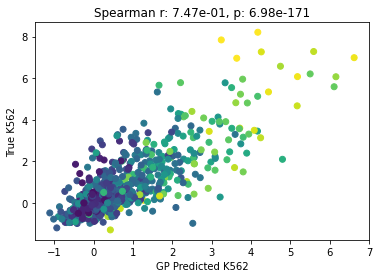

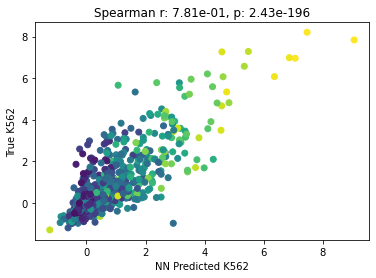

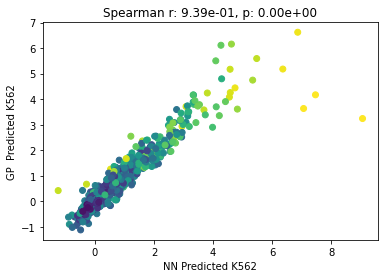

In [25]:
plt.scatter( mean.cpu().numpy(), Y.cpu().numpy(), c=(upper-lower).cpu().numpy(), cmap='viridis' )
corr, pval = spearmanr( mean.cpu().numpy(), Y.cpu().numpy() )
plt.title("Spearman r: {:.2e}, p: {:.2e}".format(corr,pval))
plt.xlabel("GP Predicted K562")
plt.ylabel("True K562")
plt.show()

plt.scatter( preds_test[:,0].cpu().numpy(), Y.cpu().numpy(), c=(upper-lower).cpu().numpy(), cmap='viridis' )
corr, pval = spearmanr( preds_test[:,0].cpu().numpy(), Y.cpu().numpy() )
plt.title("Spearman r: {:.2e}, p: {:.2e}".format(corr,pval))
plt.xlabel("NN Predicted K562")
plt.ylabel("True K562")
plt.show()

plt.scatter( preds_test[:,0].cpu().numpy(), mean.cpu().numpy(), c=(upper-lower).cpu().numpy(), cmap='viridis' )
corr, pval = spearmanr( preds_test[:,0].cpu().numpy(), mean.cpu().numpy() )
plt.title("Spearman r: {:.2e}, p: {:.2e}".format(corr,pval))
plt.xlabel("NN Predicted K562")
plt.ylabel("GP  Predicted K562")
plt.show()


In [26]:
from sklearn.decomposition import PCA

dim_red = PCA(n_components = 3)

seq_pca = dim_red.fit_transform(encoded.cpu().numpy())
seq_pca_test = dim_red.transform(encoded_test.cpu().numpy())


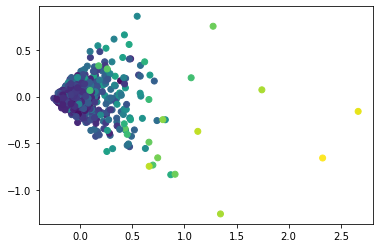

In [27]:
plt.scatter( seq_pca_test[:,0], seq_pca_test[:,1], c=Y.cpu().numpy(), cmap='viridis' )
plt.show()

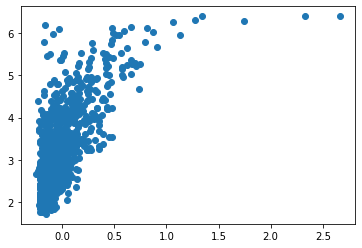

In [28]:
plt.scatter( seq_pca_test[:,0], (upper-lower).cpu().numpy() )
plt.show()

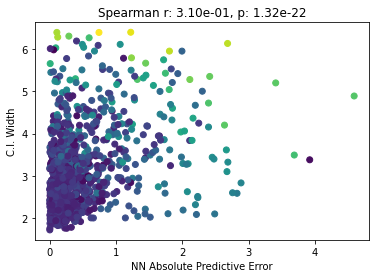

In [29]:
plt.scatter( (preds_test[:,0].cpu()-Y.cpu()).abs().numpy(), (upper-lower).cpu().numpy(), c=Y.cpu(), cmap='viridis' )
corr, pval = spearmanr( (preds_test[:,0].cpu()-Y.cpu()).abs().numpy(), (upper-lower).cpu().numpy() )
plt.title("Spearman r: {:.2e}, p: {:.2e}".format(corr,pval))
plt.xlabel("NN Absolute Predictive Error")
plt.ylabel("C.I. Width")
plt.show()


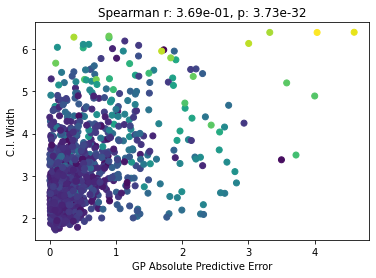

In [30]:
plt.scatter( (mean.cpu()-Y.cpu()).abs().numpy(), (upper-lower).cpu().numpy(), c=Y.cpu(), cmap='viridis' )

corr, pval = spearmanr( (mean.cpu()-Y.cpu()).abs().numpy(), (upper-lower).cpu().numpy() )
plt.title("Spearman r: {:.2e}, p: {:.2e}".format(corr,pval))
plt.xlabel("GP Absolute Predictive Error")
plt.ylabel("C.I. Width")

plt.show()


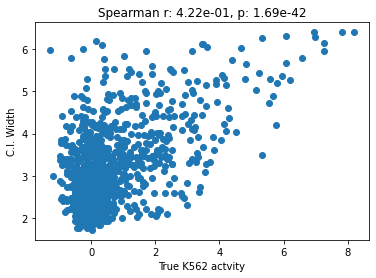

In [31]:
plt.scatter( Y.cpu().numpy(), (upper-lower).cpu().numpy() )
corr, pval = spearmanr( Y.cpu().numpy(), (upper-lower).cpu().numpy() )
plt.title("Spearman r: {:.2e}, p: {:.2e}".format(corr,pval))
plt.xlabel("True K562 actvity")
plt.ylabel("C.I. Width")
plt.show()


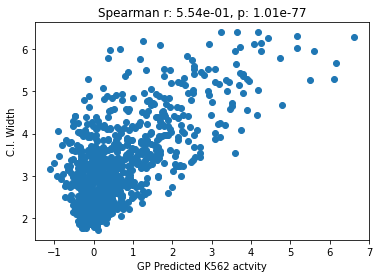

In [32]:
plt.scatter( mean.cpu().numpy(), (upper-lower).cpu().numpy() )
corr, pval = spearmanr( mean.cpu().numpy(), (upper-lower).cpu().numpy() )
plt.title("Spearman r: {:.2e}, p: {:.2e}".format(corr,pval))
plt.xlabel("GP Predicted K562 actvity")
plt.ylabel("C.I. Width")
plt.show()


import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

%matplotlib notebook

sns.set(style = "darkgrid")

fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')

x = seq_pca_test[:,0]
y = seq_pca_test[:,2]
z = mean.cpu().numpy()

ax.set_xlabel("PC1")
ax.set_ylabel("PC3")
ax.set_zlabel("K562")

ax.scatter(x, y, z, c=(upper-lower).cpu().numpy(), cmap='viridis' )

plt.show()